## Soft margin SVM
Soft margin SVM is a branch of SVM (Support Vector Machines) that allows the model to make some level of misclassifications as to make the decision boundary (SOFTER)

Specifically, it aims to solve the following dual problem 

$$
max \space \sum_{i}\alpha_i - \frac{1}{2}\sum_i \sum_j y^{(i)}y^{(j)}a_ia_j<x^{(i)}, x^{(j)}> \\
s.t. \space C \ge \alpha_i \ge 0 , \sum_i y^{(i)}\alpha_i = 0
$$

With the following KKT conditions

$$
a_i = 0 \Rightarrow y^{(i)}(w^Tx^{(i)}+b) \ge 1 \\ 
a_i = C \Rightarrow y^{(i)}(w^Tx^{(i)}+b) \le 1 \\ 
C \ge a_i \ge 0 \Rightarrow y^{(i)}(w^Tx^{(i)}+b) = 1
$$

Along side with kernel trick, SMO is one of the powerful tools that can do so. 


## Implementation

### Required Values
- **point** corresponds to the training data $x_i$
- **target** corresponds to the training outputs $y_i$
- **C** is inversely proportional to the amount of mistakes we can afford. This depends on the scale of the problem. Mostly it’s set from $.01 \to100$
- **tol** is the amount of tolerance we will have for the KKT conditions.
- **prog_margin** is the padding we will employ for the calculation of $L$ and $H$ as to not make them equal. This will also serve as our margin in determining whether the two langrange multiplier has made any positive progress.
- **clip_padding** is the padding we will apply on the constraint $C \ge a_i \ge 0$ where we wil clip $a_i$ to either $C$ or $0$ if it’s within that padding

☝🏻 tol, prog_margin and clip_padding are mostly set to $1e^-3$ to $1e^-5$

In [8]:
import numpy as np
import math

np.random.seed(42069)

M: int = 1000
D: int = 25
point = np.random.normal(size=(M, D), loc=0, scale=10).astype(np.float32)
target = np.random.choice([-1, 1], size=(M), replace=True)
c: float = 1
tol: float = 0.0001
prog_margin: float = 0.0001
clip_padding: float = 0.00000001
max_ch = 1000

### Kernel Function
Function responsible for the kernel trick

For gaussian Kernels we use the following 
$$
K(x ,z ) = exp(-\frac{||x-z||^2}{2\sigma})
$$

This can be sped up from the fact that $||x-z||^2 = x * x - 2x*z + z *z $

We can cache the dot product of vector to itself. We can also store the dot product of every 2 possible pair! but this may take a lot of memory

In [9]:
self_dot_cache: np.float32 = np.zeros(shape=(M), dtype=np.float32)
sigma: int = 10

# initialize self_dot_cache
def initialize_sdc() -> None: 
    for i in range(M):
        self_dot_cache[i] = np.dot(point[i], point[i])

def kernel_gaussian(x: np.float32, z: np.array, cache_x: int=-1, cache_z: int=-1) -> float:
    '''
    cache_x and cache_z allows us to determine whether x and z are stored in self_dot_cache.
    This helps us calculate the dot product of a vector with itself easier
    '''
    dot_xx: float = self_dot_cache[cache_x] if cache_x > -1 else np.dot(x, x)
    dot_zz: float = self_dot_cache[cache_z] if cache_z > -1 else np.dot(z, z)
    return math.e**((-1/(2 * sigma)) * (dot_xx - (2 * np.dot(x, z)) + dot_zz))

initialize_sdc()

### Helper Functions

In [10]:
def compute_svm_err(x: int, alphs: np.float32, err_cache: np.float32, b: np.float32) -> np.float32:
    fx: np.float32 = obj_x(point[x], alphs, b, cache_val=x)
    err_cache[x] = fx - target[x]

    print("svm err", err_cache[x])
    return err_cache[x]

def obj_x(val: np.float32, alphs: np.float32, b: float, cache_val: int=-1) -> np.float32:
    print("computing fx")
    fx: np.float32 = -b
    
    for i in range(M):
        if (alphs[i] == 0):
            continue
        
        K: np.float32 = kernel_gaussian(point[i], val, cache_x=i, cache_z=cache_val)
        fx += alphs[i] * target[i] * K

    print("done (f(x))", fx)
    return fx 

def accuracy(alphs: np.float32, b: float) -> float:
    correct: int = 0
    for i in range(M):
        fx: np.float32 = obj_x(point[i], alphs, b, cache_val=i)
        correct += abs(target[i] - fx) 
    
    return correct / M


### Step Function
Lastly the function that takes a coordinate ascent step given the two multipliers

In [11]:
def take_step(i1: int, i2: int, alphs: np.float32, err_cache: np.float32, B: np.float32) -> bool:
    print(f"Taking step for {i1} and {i2}")
    if (i1 == i2):
        print("Positions equal")
        return 0
    
    non_bound: bool = alphs[i1] != 0 and alphs[i1] != c
    b: float = B[0]

    E1: float = err_cache[i1] if non_bound else compute_svm_err(i1, alphs, err_cache, b)
    E2: float = err_cache[i2] 
    y1: int = target[i1]
    y2: int = target[i2]
    alph1: float = alphs[i1]
    alph2: float = alphs[i2]
    s: int = y1 * y2

    # Computation for L and H
    if (y1 == y2):
        L: float = max(0, alph1 + alph2 - c)
        H: float = min(c, alph1 + alph2)
    else:
        L: float = max(0, alph2 - alph1)
        H: float = min(c, c + alph2 - alph1)

    if (L == H):
        print("L and H equal")
        return 0
    
    K11: float = kernel_gaussian(point[i1], point[i1], cache_x=i1, cache_z=i1)
    K22: float = kernel_gaussian(point[i2], point[i2], cache_x=i2, cache_z=i2)
    K12: float = kernel_gaussian(point[i1], point[i2], cache_x=i1, cache_z=i2)
    eta: float = (2*K12)- K11 - K22

    if (eta < 0):
        alph2_new: float = alph2 - (y2*(E1 - E2)/eta)
        if (alph2_new < L):
            alph2_new = L
        elif (alph2_new > H):
            alph2_new = H
    else:
        zeta: float = (y1*alph1 + y2*alph2)
        v1: float = obj_x(point[i1], alphs, b, i1) + b - (alph1 * y1 * K11) - (alph2 * y2 * K12)  
        v2: float = obj_x(point[i2], alphs, b, i2) + b - (alph1 * y1 * K12) - (alph2 * y2 * K22) 
        Lobj: float = (L*(1 - s)) + (zeta * s * L * K11) - (.5*L*L*(K11 + K22)) - ((zeta - s*L)*(s*L*K12)) + ((v1 - v2)*(y2*L))
        Hobj: float = (H*(1 - s)) + (zeta * s * H * K11) - (.5*H*H*(K11 + K22)) - ((zeta - s*H)*(s*H*K12)) + ((v1 - v2)*(y2*H))

        if (Lobj < Hobj - prog_margin):
            alph2_new: float = H
        elif (Lobj > Hobj + prog_margin):
            alph2_new: float = L    
        else:
            alph2_new: float = alph2

    # clip
    if (alph2_new < clip_padding):
        alph2_new = 0
    elif (alph2_new > c - clip_padding):
        alph2_new = c
        
    if (abs(alph2_new - alph2) < (prog_margin * (alph2_new + alph2 + prog_margin))):
        print("Bad progress")
        return 0
    
    alph1_new: float = alph1 + (s*(alph2 - alph2_new))

    # update tresholds
    b1: float = E1 + y1*K11*(alph1_new - alph1) + y2*K12*(alph2_new - alph2) + b
    b2: float = E2 + y1*K12*(alph1_new - alph1) + y2*K22*(alph2_new - alph2) + b
    B[0] = (b1/2) + (b2/2)
    
    # update err_cache
    err_cache[i1], err_cache[i2] = 0, 0
    for i in range(M):
        if (alphs[i] == 0 or alphs[i] == c or i == i1 or i == i2):
            continue
        
        K1k: float = kernel_gaussian(point[i], point[i1], cache_x=i, cache_z=i1)
        K2k: float = kernel_gaussian(point[i], point[i2], cache_x=i, cache_z=i2)

        err_cache[i] = err_cache[i] + y1*K1k*(alph1_new - alph1) + y2*K2k*(alph2_new - alph2) + b - B[0]
    
    # update alphs
    alphs[i1], alphs[i2] = alph1_new, alph2_new
    
    '''
    print(f"======= Step successful for {i1} and {i2} =======")
    print(f"a1: {alph1} -> {alph1_new} | a2: {alph2} -> {alph2_new}")
    print(f"b: {b} -> {B[0]}")
    print(f"err_cache: {err_cache}")
    print("==================================================")
    '''
    return 1

### Examine Alpha Function
The second function which is responsible for checking the first langrange multiplier that is chosen and responsible for picking the next langrange multiplier

In [12]:
def examine_a(i2: int, alphs: np.array, err_cache: np.array, B: np.float32) -> bool:
    non_bound: bool = alphs[i2] != 0 and alphs[i2] != c
    b: float = B[0]
    E2: float = err_cache[i2] if non_bound else compute_svm_err(i2, alphs, err_cache, b)
    r2: float = E2 * target[i2]
    alph2: float = alphs[i2]

    if ((r2 < -tol and alph2 < c) or (r2 > tol and alph2 > 0)):
        print("choosing second multipier")
        # count number of non-zero entries (can be optimized)
        if (non_zeros_ge_one(alphs, i2)):
            i1: int = choose_second(i2, err_cache)
            if (take_step(i1, i2, alphs, err_cache, B)):
                return 1

        # take non-bound alps
        start: int = np.random.randint(size=(1), low=0, high=M)[0]
        for i in range(M):
            pos: int = (start + i)%M
            if (alphs[pos] ==  c or alphs[pos] == 0):
                continue

            if (take_step(pos, i2, alphs, err_cache, B)):
                return 1
        
        # loop through entire training set
        for i in range(M):
            if (take_step((start + i)%M, i2, alphs, err_cache, B)):
                return 1
    
    print("already satisfy kkt conditions")
    return 0

def non_zeros_ge_one(alphs: np.float32, first: int) -> bool:
    for i in range(M):
        if i != first and alphs[i] != 0 and alphs[i] != c:
            return 1
    
    return 0

def choose_second(first: int, err_cache: np.float32) -> int:
    pos: bool = err_cache[first] > 0
    best: int = first

    for i in range(M):
        if (i == first):
            continue

        if (best == first):
            best = i
        elif (pos and err_cache[i] < err_cache[best]):
            best = i
        elif (not pos and err_cache[i] > err_cache[best]):
            best = i

    return best

### Train Function
The train function which is responsible for picking the first langrange multiplier from a set of langrange multipliers. It is also responsible for initializing the important variables

In [13]:
def smo_train() -> object:
    alphs: np.float32 = np.zeros(shape=(M), dtype=np.float32)
    err_cache: np.float32 = np.zeros(shape=(M), dtype=np.float32)
    B: np.float32 = np.array([0.], dtype=np.float32)

    examine_all: bool = True
    num_changed: int = 0
    total_changed: int = 0

    while (num_changed > 0 or examine_all):
        print("choosing first multiplier")
        num_changed = 0
        for i in range(M):
            if (examine_all or (alphs[i] != 0 and alphs[i] != c)):
                num_changed += examine_a(i, alphs, err_cache, B)

        if (examine_all):
            examine_all = False
        
        elif (num_changed == 0):
            examine_all = True

        total_changed += num_changed
        if total_changed > max_ch: 
                    return {"alphs": alphs, "err_cache": err_cache, "b": B[0]} 
        
        print("total iterations: ", total_changed)
    
    print(err_cache)
    return {"alphs": alphs, "err_cache": err_cache, "b": B[0]}

### Test

choosing first multiplier
computing fx
done (f(x)) -0.0
svm err -1.0
choosing second multipier
Taking step for 519 and 0
computing fx
done (f(x)) -0.0
svm err -1.0
L and H equal
Taking step for 520 and 0
computing fx
done (f(x)) -0.0
svm err -1.0
L and H equal
Taking step for 521 and 0
computing fx
done (f(x)) -0.0
svm err -1.0
L and H equal
Taking step for 522 and 0
computing fx
done (f(x)) -0.0
svm err 1.0
computing fx
done (f(x)) 1.0485497177430544e-100
svm err 1.0
choosing second multipier
Taking step for 519 and 1
computing fx
done (f(x)) -2.5109024685259102e-102
svm err -1.0
computing fx
done (f(x)) 1.4676927978083612e-97
svm err -1.0
choosing second multipier
Taking step for 0 and 2
computing fx
done (f(x)) 0.5
svm err -0.5
choosing second multipier
Taking step for 1 and 3
computing fx
done (f(x)) 0.5
svm err 1.5
choosing second multipier
Taking step for 520 and 4
computing fx
done (f(x)) 0.5
svm err -0.5
computing fx
done (f(x)) 4.186344329486434e-90
svm err 1.0
choosing second

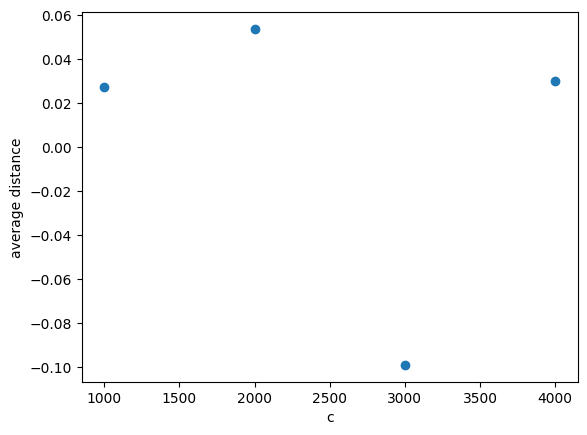

In [20]:
import matplotlib.pyplot as plt

x = [i*1000 for i in range(1, 5)]
y = []

for i in range(len(x)):
    c = x[i]
    res = smo_train()
    y.append(accuracy(res["alphs"], res["b"]))
    
plt.xlabel("c")
plt.ylabel("average distance")
plt.scatter(x, y)

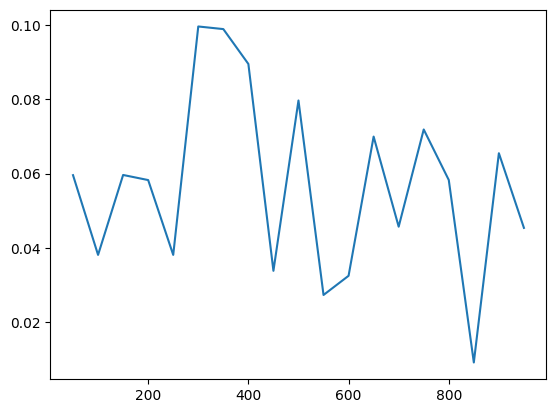

In [19]:
plt.plot(x, [abs(i) for i in y])